In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
# import Gridspec
from matplotlib.gridspec import GridSpec

# Results

In [2]:
def create_method_colors(df):
    """Create a consistent color mapping for methods"""
    methods = sorted(df['steering_method'].unique())  # Sort to ensure consistent order
    colors = sns.color_palette('deep', n_colors=len(methods))
    # Make the "do_nothing" gray
    # colors[methods.index('do_nothing')] = '#95a5a6'
    return dict(zip(methods, colors))

def plot_radar_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create radar plots comparing behavior and coherence scores across methods.
    
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence'
        save_path: Optional path to save the plot
    """
    # Set up the figure
    fig = plt.figure(figsize=(20, 6))
    gs = GridSpec(1, 2, width_ratios=[1, 1])
    
    # Create axes
    ax_radar_behavior = fig.add_subplot(gs[0], projection='polar')
    ax_radar_coherence = fig.add_subplot(gs[1], projection='polar')
    
    # Create consistent color mapping
    method_colors = create_method_colors(df)
    
    # Plot each metric
    plot_radar_metric(df, 'behavior', ax_radar_behavior, method_colors, show_legend=True)
    plot_radar_metric(df, 'coherence', ax_radar_coherence, method_colors, show_legend=False)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Radar plot saved to {save_path}")
    
    plt.show()

def plot_distribution_comparison(df: pd.DataFrame, save_path: str = None):
    """
    Create distribution plots comparing behavior and coherence scores across methods.
    
    Args:
        df: DataFrame with columns 'steering_method', 'query', 'behavior', 'coherence'
        save_path: Optional path to save the plot
    """
    # Create consistent color mapping
    method_colors = create_method_colors(df)
    
    # Set up the figure
    fig, (ax_behavior, ax_coherence) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot distributions
    plot_violin(df, 'behavior', ax_behavior, method_colors)
    plot_violin(df, 'coherence', ax_coherence, method_colors)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Distribution plot saved to {save_path}")
    
    plt.show()

def plot_radar_metric(df: pd.DataFrame, metric: str, ax: plt.Axes, method_colors, show_legend=False):
    """Helper function to create radar plot for a specific metric"""
    # Calculate mean and std scores per query and method
    means = df.groupby(['query', 'steering_method'])[metric].mean().unstack()
    stds = df.groupby(['query', 'steering_method'])[metric].std().unstack()
    
    # Set up the angles for the radar chart
    num_queries = len(means.index)
    angles = np.linspace(0, 2 * np.pi, num_queries, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the plot
    
    # Define method order
    method_order = ['Control', 'Simple Prompting', 'AutoSteer', 'Agentic', 'Combined Approach']
    
    # Plot each method in specified order
    for method in method_order:
        if method not in means.columns:
            continue
            
        values = means[method].values
        std_values = stds[method].values
        
        # Close the values
        values = np.concatenate((values, [values[0]]))
        std_values = np.concatenate((std_values, [std_values[0]]))
        
        # Plot mean line using consistent color mapping
        if method == 'Control':  # if the method is Control, make it dotted
            ax.plot(angles, values, 'o--', label=method, 
                color=method_colors[method], alpha=0.8, linewidth=2, markersize=8)
        else:
            ax.plot(angles, values, 'o-', label=method, 
                color=method_colors[method], alpha=0.8, linewidth=2, markersize=8)
        
        # Add uncertainty region
        upper = values + std_values
        lower = values - std_values
        # Plot error bars at each point
        for i in range(len(angles)):
            # Plot vertical error bar line
            ax.plot([angles[i], angles[i]], [lower[i], upper[i]], 
                   color=method_colors[method], alpha=0.3, linewidth=2)
            # Add caps at top and bottom
            cap_width = 0.1
            ax.plot([angles[i]-cap_width/2, angles[i]+cap_width/2], [upper[i], upper[i]],
                   color=method_colors[method], alpha=0.3, linewidth=2)
            ax.plot([angles[i]-cap_width/2, angles[i]+cap_width/2], [lower[i], lower[i]],
                   color=method_colors[method], alpha=0.3, linewidth=2)
    
    # Set up the labels
    ax.set_xticks(angles[:-1])
    
    # Format labels to be shorter
    label_mapping = {
        'be empathetic and supportive': 'Empathetic',
        'be educational and explain like a teacher': 'Educational',
        'be diplomatic and balanced': 'Diplomatic',
        'be creative with metaphors and analogies': 'Creative',
        'be concise and direct': 'Concise',
        'be technical and detailed': 'Technical',
        'be skeptical and analytical': 'Analytical',
        'be professional and formal': 'Professional',
        'be motivational and inspiring': 'Motivational',
        'be more creative and imaginative': 'Imaginative',
        'be like a journalist': 'Journalistic',
        'be funny': 'Humorous'
    }
    
    labels = means.index
    formatted_labels = [label_mapping.get(label, label) for label in labels]
    
    # Set formatted labels with a small radial offset
    ax.set_xticklabels(formatted_labels, size=12)
    ax.tick_params(pad=15)  # Increase the padding between tick labels and plot
    
    # Set up the scales
    ax.set_ylim(0.5, 5.5)
    ax.set_rticks([1, 2, 3, 4, 5])
    
    # Add legend only to the behavior plot
    if show_legend:
        ax.legend(bbox_to_anchor=(1.4, 1), loc='center', fontsize=14)
    
    # Add title
    ax.set_title(f'{metric.capitalize()} Scores Across Queries', 
                 pad=20, fontsize=20, y=1.1)

def plot_violin(df: pd.DataFrame, metric: str, ax: plt.Axes, method_colors):
    """Helper function to create distribution plot for a given metric"""
    # Create violin plot with consistent colors
    # First, ensure methods are in the same order as the color mapping
    order = ['Control', 'Simple Prompting', 'AutoSteer', 'Agentic', 'Combined Approach']
    sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
                  inner='box', order=order,
                  palette=[method_colors[m] for m in order],
                  bw_method='scott', gridsize=100, common_norm=True)
    
    # Add mean markers
    means = df.groupby('steering_method')[metric].mean()
    for i, method in enumerate(order):
        ax.plot(i, means[method], 'o', color='white', markersize=10, zorder=3)
        ax.plot(i, means[method], 'o', color='black', markersize=6, zorder=4)
    
    # Customize plot
    ax.set_xlabel('', fontsize=18)
    ax.set_ylabel(f'{metric.capitalize()} Score', fontsize=18)
    ax.set_title(f'{metric.capitalize()} Score Distributions', 
                 pad=20, fontsize=20)
    
    # Rotate x-labels for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=16)
    
    # Set y-axis limits
    ax.set_ylim(0.5, 5.5)
    ax.set_yticks(range(1, 6))
    
    # Add grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Llama-3.1

In [3]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.1_dt_20250123.csv')

Radar plot saved to results/llama_3-1_8b_radar.jpg


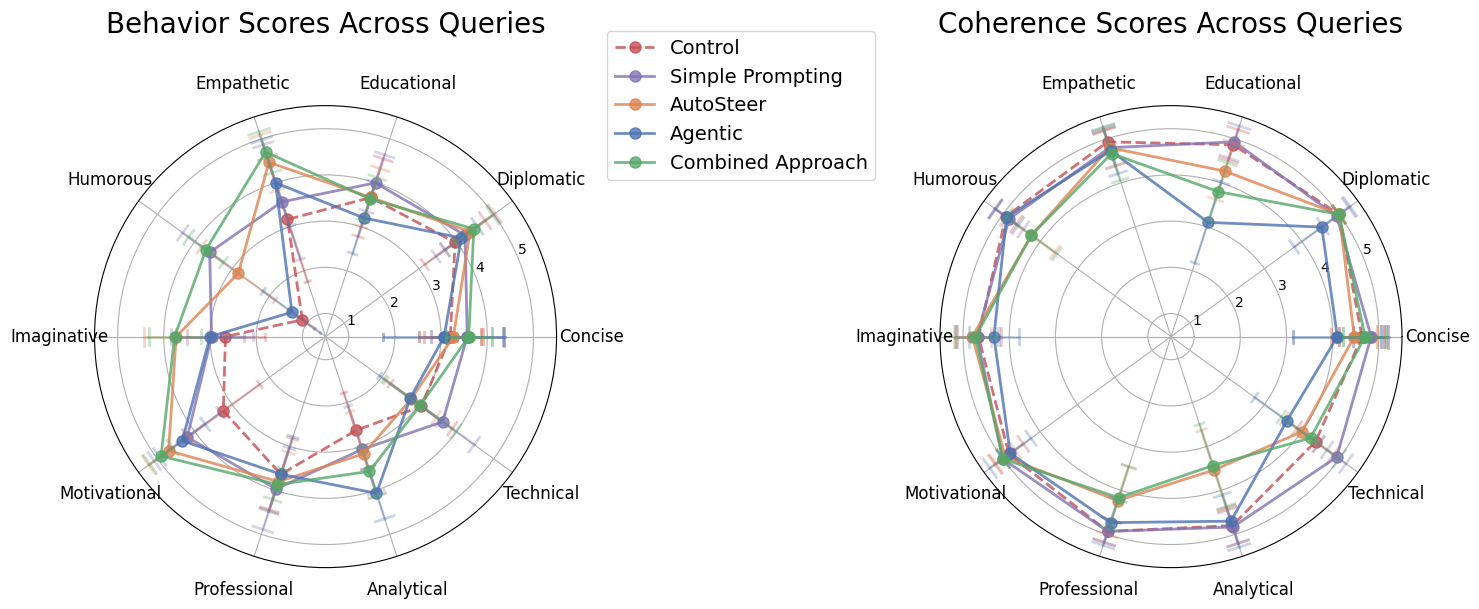

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=16)
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel

Distribution plot saved to results/llama_3-1_8b_violin.jpg


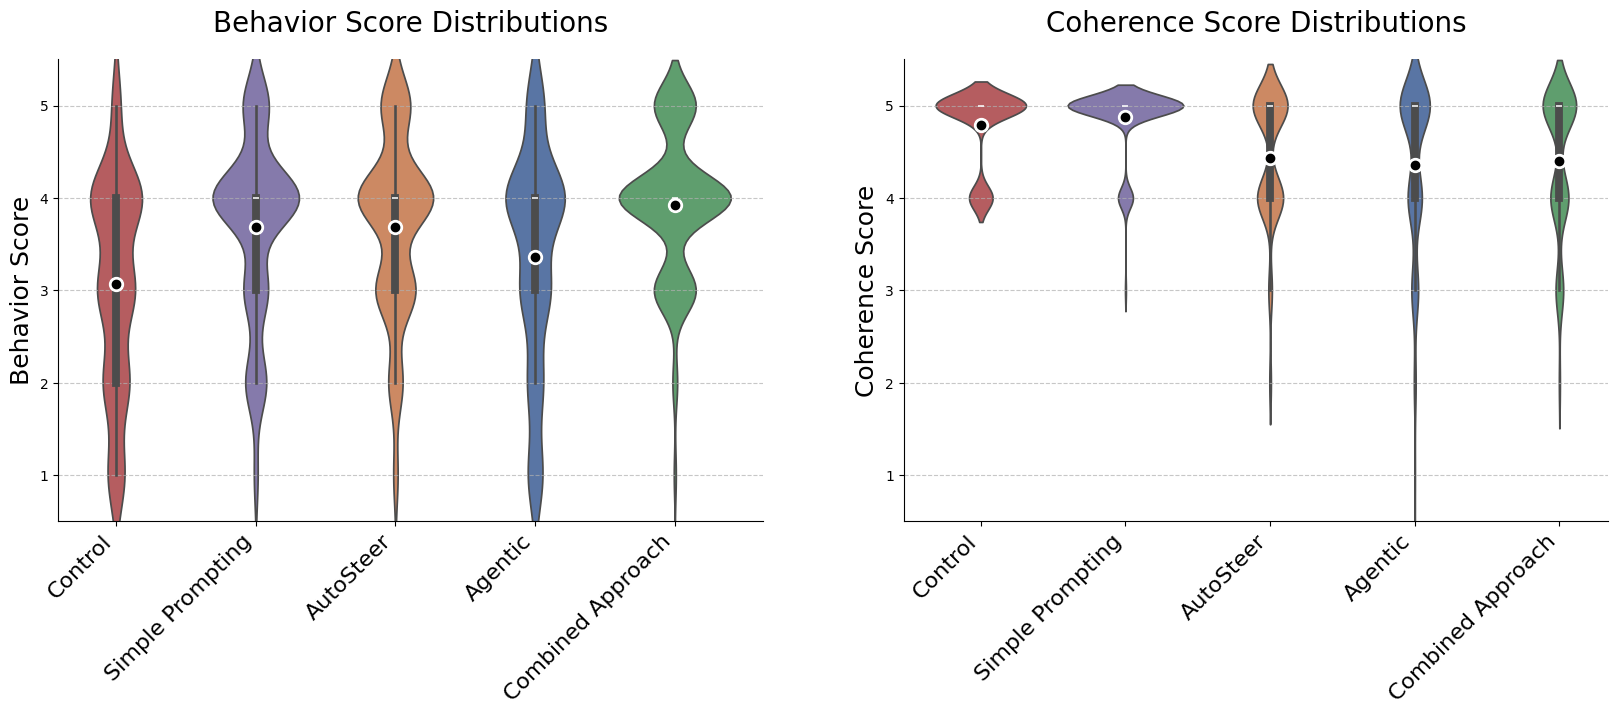

In [4]:
plot_radar_comparison(df, save_path='results/llama_3-1_8b_radar.jpg')
plot_distribution_comparison(df, save_path='results/llama_3-1_8b_violin.jpg')

## Llama-3.3

In [5]:
df = pd.read_csv('results/eval_gpt-4o-mini_var_llama-3.3_dt_20250124.csv')

Radar plot saved to results/llama_3-3_70b_radar.jpg


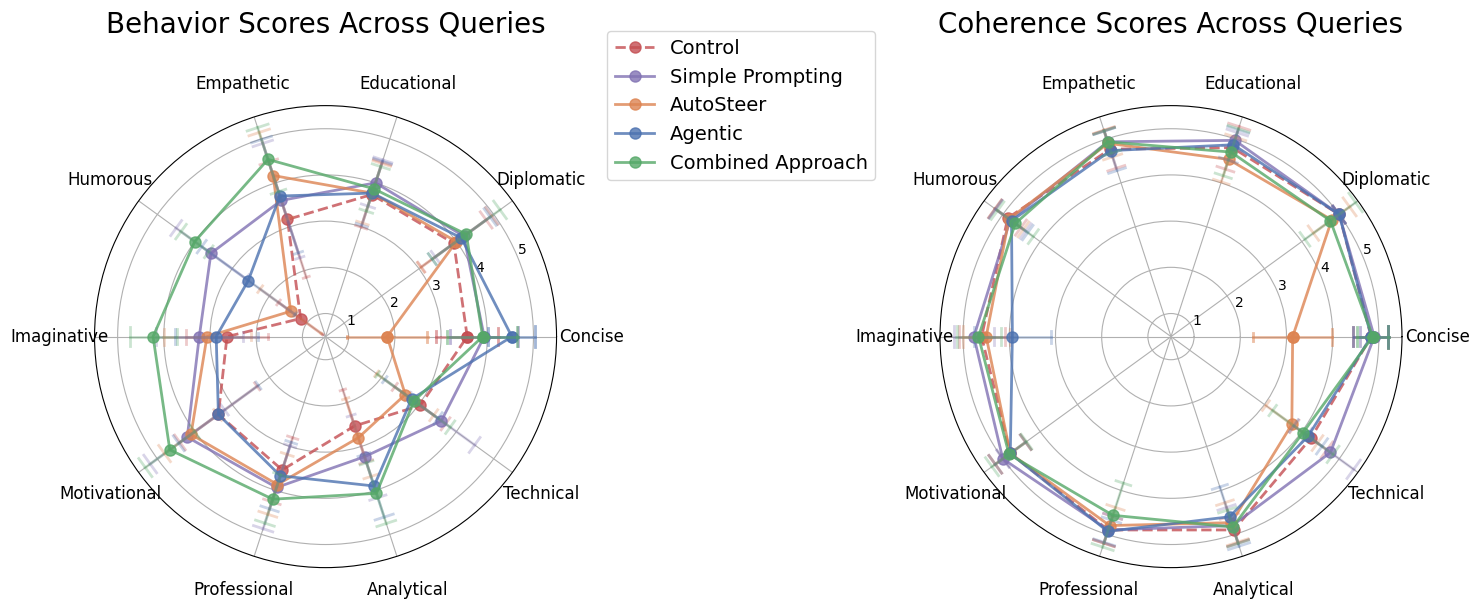

/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:175: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=16)
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel_51920/4265366282.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='steering_method', y=metric, ax=ax,
/var/folders/m6/dj2mn85s7jg_r9ptl4kt_6q80000gn/T/ipykernel

Distribution plot saved to results/llama_3-3_70b_violin.jpg


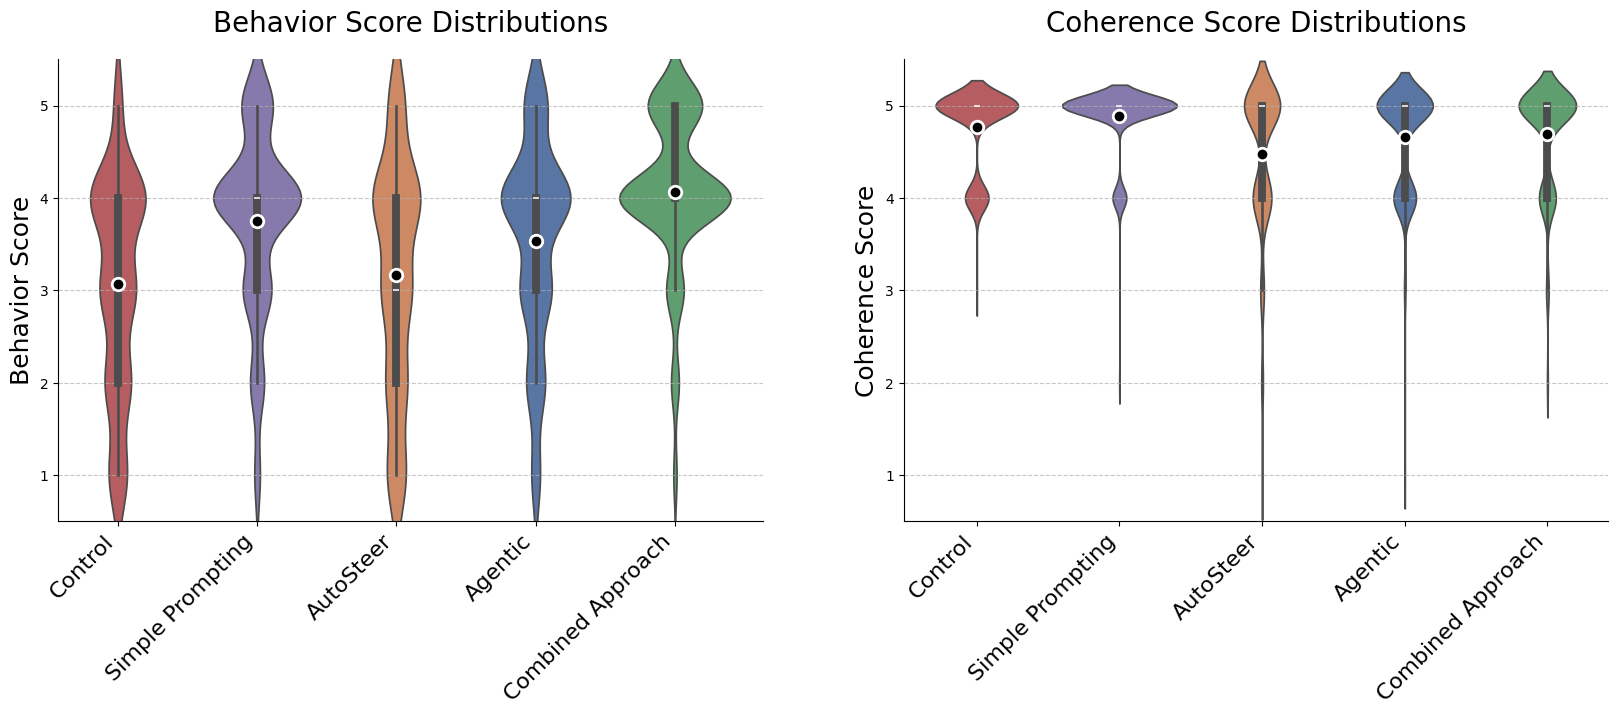

In [6]:
plot_radar_comparison(df, save_path='results/llama_3-3_70b_radar.jpg')
plot_distribution_comparison(df, save_path='results/llama_3-3_70b_violin.jpg')

## Appendix: Coherence Fail Cases

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df[df['coherence'] < 2][['query', 'system_prompt', 'user_prompt', 'steering_method', 'response', 'analysis', 'behavior', 'coherence']]

query                 system_prompt  \
844         be technical and detailed  You are a helpful assistant.   
971  be more creative and imaginative  You are a helpful assistant.   

                        user_prompt steering_method  \
844  Describe TCP/IP protocol stack       AutoSteer   
971  Building healthy relationships         Agentic   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    